### Quickstart
To run the code below:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button
   (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

Feel free to create new cells using the plus button
(<button class='fa fa-plus icon-plus btn btn-xs btn-default'></button>), or pressing `SHIFT+ENTER` while this cell
is selected.

# Appendix 4: multicompartmental modeling

This example demonstrates multicompartmental modeling in Brian 2. It partly reproduces Figure 9C from the following paper:

Dendritic Low-Threshold Calcium Currents in Thalamic Relay Cells
Alain Destexhe, Mike Neubig, Daniel Ulrich, John Huguenard
Journal of Neuroscience 15 May 1998, 18 (10) 3574-3588

The original NEURON code is available on ModelDB:  
https://senselab.med.yale.edu/modeldb/ShowModel.cshtml?model=279 

Reference for the original morphology:  
Rat VB neuron (thalamocortical cell), given by J. Huguenard, stained with
biocytin and traced by A. Destexhe, December 1992.  The neuron is described
in: J.R. Huguenard & D.A. Prince, A novel T-type current underlies prolonged
calcium-dependent burst firing in GABAergic neurons of rat thalamic reticular
nucleus.  J. Neurosci. 12: 3804-3817, 1992.

Available at NeuroMorpho.org:
http://neuromorpho.org/neuron_info.jsp?neuron_name=tc200  
NeuroMorpho.Org ID :NMO_00881

The code makes use of physical constants defined in Brian's `brian2.units.constants` package, and of a plotting function defined as parts of the external `brian2tools` package (https://brian2tools.readthedocs.io ):

In [1]:
from brian2 import *
from brian2.units.constants import (zero_celsius, faraday_constant as F,
                                    gas_constant as R)
from brian2tools import plot_morphology

We switch on plotting in the notebook:

In [2]:
%matplotlib notebook

We set the integration time step and set a couple of constants:

In [3]:
defaultclock.dt = 0.01*ms

VT = -52*mV
El = -76.5*mV 
gl = 0.0379*msiemens/cm**2

E_Na = 50*mV
E_K = -100*mV

T = 34*kelvin + zero_celsius # 34 degC (current-clamp experiments)
tadj_HH = 3.0**((34-36)/10.0)  # temperature adjustment for Na & K (original recordings at 36 degC)
tadj_m_T = 2.5**((34-24)/10.0)
tadj_h_T = 2.5**((34-24)/10.0)

shift_I_T = -1*mV

gamma = F/(R*T)  # R=gas constant, F=Faraday constant
Z_Ca = 2  # Valence of Calcium ions
Ca_i = 240*nM  # intracellular Calcium concentration
Ca_o = 2*mM  # extracellular Calcium concentration

The neuron's membrane equations are described in the same formalism used for single compartment models with three exceptions:
1. The membrane potential is automatically defined as `v`
2. The user has to provide an equation for the transmembrane current `Im` (as a current per area)
3. Currents injected at a particular point (e.g. provided by electrodes or synapses), can be declared as a `point current` and will be automatically added to the membrane equations (divided by the area of the respective compartment)

In [4]:
eqs = Equations('''
Im = gl*(El-v) - I_Na - I_K - I_T: amp/meter**2
I_inj : amp (point current)

# HH-type currents for spike initiation
g_Na : siemens/meter**2
g_K : siemens/meter**2
I_Na = g_Na * m**3 * h * (v-E_Na) : amp/meter**2
I_K = g_K * n**4 * (v-E_K) : amp/meter**2
v2 = v - VT : volt  # shifted membrane potential (Traub convention)
dm/dt = (0.32*(mV**-1)*(13.*mV-v2)/
        (exp((13.*mV-v2)/(4.*mV))-1.)*(1-m)-0.28*(mV**-1)*(v2-40.*mV)/
        (exp((v2-40.*mV)/(5.*mV))-1.)*m) / ms * tadj_HH: 1
dn/dt = (0.032*(mV**-1)*(15.*mV-v2)/
        (exp((15.*mV-v2)/(5.*mV))-1.)*(1.-n)-.5*exp((10.*mV-v2)/(40.*mV))*n) / ms * tadj_HH: 1
dh/dt = (0.128*exp((17.*mV-v2)/(18.*mV))*(1.-h)-4./(1+exp((40.*mV-v2)/(5.*mV)))*h) / ms * tadj_HH: 1

# Low-threshold Calcium current (I_T)  -- nonlinear function of voltage
I_T = P_Ca * m_T**2*h_T * G_Ca : amp/meter**2
P_Ca : meter/second  # maximum Permeability to Calcium
G_Ca = Z_Ca**2*F*v*gamma*(Ca_i - Ca_o*exp(-Z_Ca*gamma*v))/(1 - exp(-Z_Ca*gamma*v)) : coulomb/meter**3
dm_T/dt = -(m_T - m_T_inf)/tau_m_T : 1
dh_T/dt = -(h_T - h_T_inf)/tau_h_T : 1
m_T_inf = 1/(1 + exp(-(v/mV + 56)/6.2)) : 1
h_T_inf = 1/(1 + exp((v/mV + 80)/4)) : 1
tau_m_T = (0.612 + 1.0/(exp(-(v/mV + 131)/16.7) + exp((v/mV + 15.8)/18.2))) * ms / tadj_m_T: second
tau_h_T = (int(v<-81*mV) * exp((v/mV + 466)/66.6) +
           int(v>=-81*mV) * (28 + exp(-(v/mV + 21)/10.5))) * ms / tadj_h_T: second
''')

Multicompartment models have to specify the morphology of the cell, either by loading them from a file or by constructing it. The model is then instantiated by creating a `SpatialNeuron`:

In [5]:
# Load morphology from SWC file
morpho = Morphology.from_file('tc200.CNG.swc')
neuron = SpatialNeuron(morpho, eqs, Cm=0.88*uF/cm**2, Ri=173*ohm*cm,
                       method='exponential_euler')

Compartment-specific values, such as the initial membrane potential, or the densitities of ion channels, can be set for the whole neuron or for individual compartments:

In [6]:
neuron.v = -74*mV
# Only the soma has Na/K channels
neuron.main.g_Na = 100*msiemens/cm**2
neuron.main.g_K = 100*msiemens/cm**2

neuron.m_T = 'm_T_inf'
neuron.h_T = 'h_T_inf'

neuron.P_Ca = 1.7e-5*cm/second
# Distal dendrites
neuron.P_Ca['(distance + length/2) > 11*um'] = 8.5e-5*cm/second

mon = StateMonitor(neuron, ['v'], record=morpho[0])  # Record at soma
cutoff = 100*ms  # we'll ignore the first 100ms
# Switch off monitor during initial transient
mon.active = False
run(cutoff)
mon.active = True
run(80 * ms)
neuron.main.I_inj = 75*pA
run(320*ms)

<IPython.core.display.Javascript object>


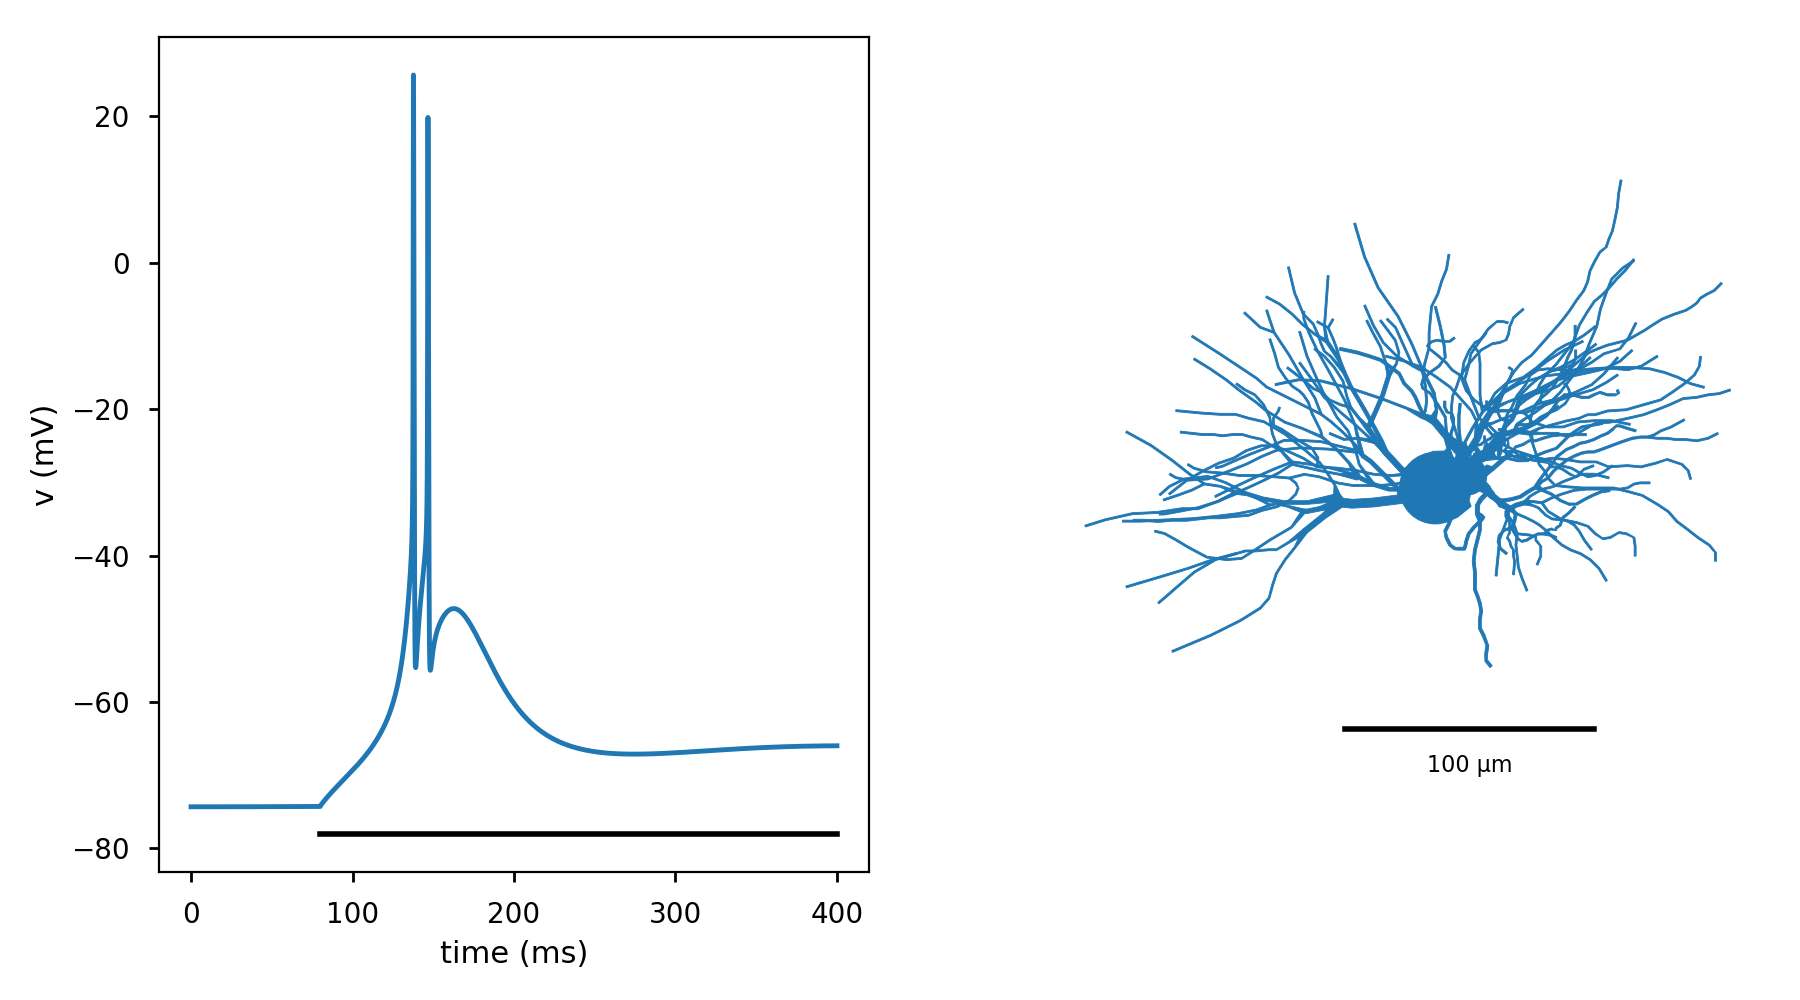

In [11]:
# Plot simulation results
plt.style.use('seaborn-notebook')
fig, (ax_sim, ax_morphology) = plt.subplots(1, 2, figsize=(9, 5))
ax_sim.plot((mon.t - cutoff)/ms, mon.v[0]/mV)
# Show the time of current injection
ax_sim.plot([80, 400], [-78, -78], 'k', lw=2)
ax_sim.set(xlabel='time (ms)', ylabel='v (mV)')
# Plot morphology
plot_morphology(morpho, plot_3d=False, show_diameter=True, colors=('C0',),
                axes=ax_morphology)
ax_morphology.set_axis_off()
ax_morphology.plot([-50, 50], [-100, -100], 'k', lw=2)
ax_morphology.annotate(u'100 μm', xy=(50, -100),
                       xytext=(0, -110), horizontalalignment='center',
                       verticalalignment='top', annotation_clip=False,
                       fontsize=8)
fig.tight_layout()